In [24]:
#vamos a probar modelos de ML
#leamos x_train, y_train, x_test, y_test
import pandas as pd
x_train = pd.read_csv("x_train.csv")
y_train = pd.read_csv("y_train.csv")
x_test = pd.read_csv("x_val.csv")
y_test = pd.read_csv("y_val.csv")




In [19]:
# En este modelo
# i) no estoy haciendo busqueda de hiperparámetros
# iii) no estoy seleccionando variables (probablmente podría eliminar 90 de las 120 features que estoy usando)
# iv) solo estoy usando 1 modelo (Random Forest)
# El modelo debe funcionar bien porque definí algunas características importantes en el dataset (lags, rolling means, etc)
# pero no es un modelo optimizado ni final. Solo es para tener una línea base de desempeño.
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
X_train_ready = pd.DataFrame(pt.fit_transform(x_train), columns=x_train.columns)
X_test_ready = pd.DataFrame(pt.transform(x_test), columns=x_test.columns)
model = RandomForestRegressor(n_estimators=1000, random_state=42)
model.fit(X_train_ready, y_train)
y_pred = model.predict(X_test_ready)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.2f}")
print(f"R2: {r2:.2f}")


c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


MSE: 11366494.07
R2: 0.28


In [20]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.2f}")

MAE: 2640.42


Feature importances:
                    feature  importance
76                Frio (Kw)    0.254023
134   Frio_roll_mean_7_lag1    0.135536
72            Sala Maq (Kw)    0.060700
67            Envasado (Kw)    0.034579
136  Frio_roll_mean_14_lag1    0.022266
71           Servicios (Kw)    0.013299
38            ET Linea 5/Hl    0.009124
0            EE Planta / Hl    0.008835
12              EE CO2 / Hl    0.008786
78           Prod Agua (Kw)    0.008358
53        CO 2 Linea 4 / Hl    0.008222
61            Hl Cerveza L4    0.008001
83    Agua Elaboracion (Hl)    0.007341
15             EE Agua / Hl    0.007233
7           EE Linea 4 / Hl    0.007159
40         Aire Planta / Hl    0.006867
129          dia_semana_cos    0.006860
30           ET Planta / Hl    0.006650
73                Aire (Kw)    0.006633
100  Vapor Elaboracion (Kg)    0.006584


Text(0.5, 1.0, 'Feature Importances from Random Forest Model')

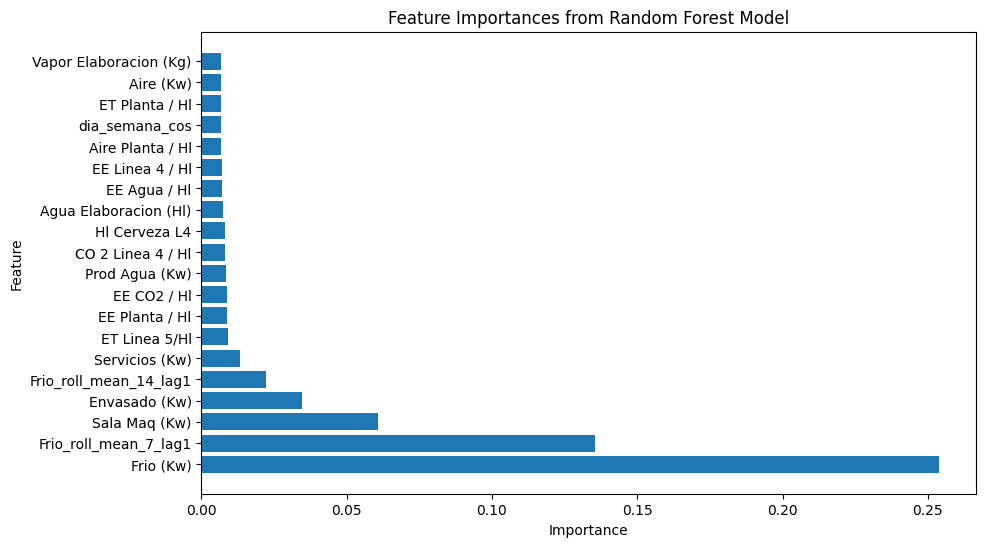

In [21]:
impartances = model.feature_importances_
feature_names = x_train.columns
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': impartances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
feature_importances = feature_importances[:20]
print("Feature importances:")
print(feature_importances)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest Model')

In [22]:
#Seleccionamos el top 20 features
x_train_top20 = x_train[feature_importances['feature']]
x_test_top20 = x_test[feature_importances['feature']]
pt = PowerTransformer(method='yeo-johnson')
X_train_top20_ready = pd.DataFrame(pt.fit_transform(x_train_top20), columns=x_train_top20.columns)
X_test_top20_ready = pd.DataFrame(pt.transform(x_test_top20), columns=x_test_top20.columns)
model_top20 = RandomForestRegressor(n_estimators=1000, random_state=42)
model_top20.fit(X_train_top20_ready, y_train)
y_pred_top20 = model_top20.predict(X_test_top20_ready)
mse_top20 = mean_squared_error(y_test, y_pred_top20)
r2_top20 = r2_score(y_test, y_pred_top20)
mae_top20 = mean_absolute_error(y_test, y_pred_top20)
print(f"Top 20 Features - MSE: {mse_top20:.2f}")
print(f"Top 20 Features - R2: {r2_top20:.2f}")
print(f"Top 20 Features - MAE: {mae_top20:.2f}")

c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Top 20 Features - MSE: 11179864.12
Top 20 Features - R2: 0.30
Top 20 Features - MAE: 2622.31


In [36]:
# ==============================
# Optuna + Pruning para LGBM
# ==============================
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
from optuna.integration import LightGBMPruningCallback

SEED = 42
VAL_FRAC = 0.20   # último 20% del train como validación temporal
N_TRIALS = 50     # ajustá según tiempo disponible

# --------- Split temporal (train -> train/valid ; test queda intacto) ---------
X_train_all = x_train.copy()
y_train_all = y_train.copy()
X_test = x_test.copy()
y_test = y_test.copy()

n = len(X_train_all)
n_val = int(np.floor(n * VAL_FRAC))
n_tr = n - n_val
X_tr, y_tr = X_train_all.iloc[:n_tr], y_train_all[:n_tr]
X_val, y_val = X_train_all.iloc[n_tr:], y_train_all[n_tr:]

print(f"Train: {X_tr.shape}, Valid: {X_val.shape}, Test: {X_test.shape}")

# --------- Función objetivo para Optuna ---------
def objective(trial: optuna.Trial) -> float:
    # Espacio de búsqueda (razonable para baseline)
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 31, 255),
        "max_depth": trial.suggest_int("max_depth", -1, 16),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "random_state": SEED,
        "n_jobs": -1
    }

    # Modelo
    model = LGBMRegressor(**params)

    # Pruning callback: monitorea 'rmse' en el primer eval_set (valid_0)
    pruning_cb = LightGBMPruningCallback(trial, metric="rmse", valid_name="valid_0")

    # Entrena con early stopping y pruning
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric="rmse",
        callbacks=[pruning_cb],
    )

    # Predicción en valid y métrica a minimizar (RMSE)
    y_pred_val = model.predict(X_val)
    rmse_val = mean_squared_error(y_val, y_pred_val)
    return rmse_val

# --------- Estudio Optuna ---------
study = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=SEED),
    pruner=MedianPruner(n_warmup_steps=10)
)
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("\n=== Mejores hiperparámetros ===")
print(study.best_params)
print(f"Mejor RMSE valid: {study.best_value:.4f}")

# --------- Re-entrenar con los mejores params (train+valid) ---------
best_params = study.best_params.copy()
best_model = LGBMRegressor(**best_params, random_state=SEED, n_jobs=-1)

best_model.fit(
    X_train_all, y_train_all,
    eval_set=[(X_val, y_val)],  # opcional, solo para logging
    eval_metric="rmse",
)

# --------- Evaluación en TEST ---------
y_pred_test = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
r2  = r2_score(y_test, y_pred_test)

print("\n=== Métricas en TEST ===")
print(f"MSE : {mse:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAE : {mae:,.2f}")
print(f"R²  : {r2:.4f}")


[I 2025-11-09 20:59:14,053] A new study created in memory with name: no-name-397f54ab-e633-4c6f-a880-8aaeb4079099


Train: (692, 140), Valid: (172, 140), Test: (94, 140)


Best trial: 0. Best value: 2.60139e+09:   2%|▏         | 1/50 [00:00<00:30,  1.58it/s]

[I 2025-11-09 20:59:14,685] Trial 0 finished with value: 2601386028.8587832 and parameters: {'n_estimators': 937, 'learning_rate': 0.17254716573280354, 'num_leaves': 195, 'max_depth': 9, 'min_child_samples': 19, 'subsample': 0.662397808134481, 'colsample_bytree': 0.6232334448672797, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 0.002570603566117598}. Best is trial 0 with value: 2601386028.8587832.


Best trial: 2. Best value: 6.69786e+08:   6%|▌         | 3/50 [00:02<00:30,  1.54it/s]

[I 2025-11-09 20:59:16,027] Trial 1 finished with value: 841451529.9436729 and parameters: {'n_estimators': 1504, 'learning_rate': 0.010636066512540286, 'num_leaves': 249, 'max_depth': 13, 'min_child_samples': 25, 'subsample': 0.6727299868828402, 'colsample_bytree': 0.6733618039413735, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 1 with value: 841451529.9436729.
[I 2025-11-09 20:59:16,201] Trial 2 finished with value: 669786028.1920238 and parameters: {'n_estimators': 1034, 'learning_rate': 0.023927528765580644, 'num_leaves': 168, 'max_depth': 1, 'min_child_samples': 33, 'subsample': 0.7465447373174767, 'colsample_bytree': 0.7824279936868144, 'reg_alpha': 0.1165691561324743, 'reg_lambda': 6.267062696005991e-07}. Best is trial 2 with value: 669786028.1920238.


Best trial: 2. Best value: 6.69786e+08:   8%|▊         | 4/50 [00:03<00:36,  1.25it/s]

[I 2025-11-09 20:59:17,229] Trial 3 finished with value: 1711103077.3870637 and parameters: {'n_estimators': 1174, 'learning_rate': 0.05898602410432694, 'num_leaves': 41, 'max_depth': 9, 'min_child_samples': 21, 'subsample': 0.6260206371941118, 'colsample_bytree': 0.9795542149013333, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936}. Best is trial 2 with value: 669786028.1920238.


Best trial: 4. Best value: 2.12532e+08:  10%|█         | 5/50 [00:03<00:28,  1.56it/s]

[I 2025-11-09 20:59:17,591] Trial 4 finished with value: 212532397.77084133 and parameters: {'n_estimators': 818, 'learning_rate': 0.013399060561509796, 'num_leaves': 184, 'max_depth': 6, 'min_child_samples': 16, 'subsample': 0.798070764044508, 'colsample_bytree': 0.6137554084460873, 'reg_alpha': 1.527156759251193, 'reg_lambda': 2.133142332373004e-06}. Best is trial 4 with value: 212532397.77084133.


Best trial: 4. Best value: 2.12532e+08:  12%|█▏        | 6/50 [00:04<00:37,  1.16it/s]

[I 2025-11-09 20:59:18,878] Trial 5 finished with value: 2135429344.3898723 and parameters: {'n_estimators': 1426, 'learning_rate': 0.02544166090938368, 'num_leaves': 148, 'max_depth': 8, 'min_child_samples': 22, 'subsample': 0.9878338511058234, 'colsample_bytree': 0.9100531293444458, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483}. Best is trial 4 with value: 212532397.77084133.


Best trial: 4. Best value: 2.12532e+08:  14%|█▍        | 7/50 [00:05<00:34,  1.26it/s]

[I 2025-11-09 20:59:19,529] Trial 6 finished with value: 400955802.2393345 and parameters: {'n_estimators': 1317, 'learning_rate': 0.15826541904647565, 'num_leaves': 50, 'max_depth': 2, 'min_child_samples': 9, 'subsample': 0.7301321323053057, 'colsample_bytree': 0.7554709158757928, 'reg_alpha': 2.7678419414850017e-06, 'reg_lambda': 0.28749982347407854}. Best is trial 4 with value: 212532397.77084133.


Best trial: 4. Best value: 2.12532e+08:  16%|█▌        | 8/50 [00:05<00:27,  1.52it/s]

[I 2025-11-09 20:59:19,899] Trial 7 finished with value: 1065621021.828747 and parameters: {'n_estimators': 906, 'learning_rate': 0.023200867504756827, 'num_leaves': 153, 'max_depth': 1, 'min_child_samples': 82, 'subsample': 0.6298202574719083, 'colsample_bytree': 0.9947547746402069, 'reg_alpha': 0.08916674715636537, 'reg_lambda': 6.143857495033091e-07}. Best is trial 4 with value: 212532397.77084133.


Best trial: 4. Best value: 2.12532e+08:  18%|█▊        | 9/50 [00:06<00:21,  1.92it/s]

[I 2025-11-09 20:59:20,117] Trial 8 finished with value: 2934665224.4459825 and parameters: {'n_estimators': 309, 'learning_rate': 0.11506408247250169, 'num_leaves': 190, 'max_depth': 12, 'min_child_samples': 79, 'subsample': 0.6296178606936361, 'colsample_bytree': 0.7433862914177091, 'reg_alpha': 1.1036250149900698e-07, 'reg_lambda': 0.5860448217200517}. Best is trial 4 with value: 212532397.77084133.


Best trial: 4. Best value: 2.12532e+08:  20%|██        | 10/50 [00:06<00:24,  1.63it/s]

[I 2025-11-09 20:59:20,935] Trial 9 finished with value: 1018437442.9789214 and parameters: {'n_estimators': 1360, 'learning_rate': 0.026946865572417687, 'num_leaves': 45, 'max_depth': 4, 'min_child_samples': 36, 'subsample': 0.8918424713352255, 'colsample_bytree': 0.8550229885420852, 'reg_alpha': 0.9658611176861268, 'reg_lambda': 0.0001778010520878397}. Best is trial 4 with value: 212532397.77084133.
[I 2025-11-09 20:59:20,981] Trial 10 pruned. Trial was pruned at iteration 10.


Best trial: 4. Best value: 2.12532e+08:  24%|██▍       | 12/50 [00:07<00:15,  2.41it/s]

[I 2025-11-09 20:59:21,319] Trial 11 finished with value: 263214873.18957448 and parameters: {'n_estimators': 613, 'learning_rate': 0.07476013380530672, 'num_leaves': 84, 'max_depth': 4, 'min_child_samples': 8, 'subsample': 0.7605900525468514, 'colsample_bytree': 0.716828566938887, 'reg_alpha': 2.3535702826591285e-05, 'reg_lambda': 9.524519477399059e-06}. Best is trial 4 with value: 212532397.77084133.


Best trial: 4. Best value: 2.12532e+08:  26%|██▌       | 13/50 [00:07<00:14,  2.50it/s]

[I 2025-11-09 20:59:21,674] Trial 12 finished with value: 1256498554.6479578 and parameters: {'n_estimators': 560, 'learning_rate': 0.06922749265952521, 'num_leaves': 97, 'max_depth': 5, 'min_child_samples': 6, 'subsample': 0.7984165248678856, 'colsample_bytree': 0.6969758134873644, 'reg_alpha': 0.0004774862169081376, 'reg_lambda': 1.1114584658963438e-05}. Best is trial 4 with value: 212532397.77084133.


Best trial: 4. Best value: 2.12532e+08:  28%|██▊       | 14/50 [00:08<00:15,  2.31it/s]

[I 2025-11-09 20:59:22,201] Trial 13 finished with value: 1541213417.7790825 and parameters: {'n_estimators': 631, 'learning_rate': 0.04170210949254517, 'num_leaves': 96, 'max_depth': 16, 'min_child_samples': 51, 'subsample': 0.8715582230144556, 'colsample_bytree': 0.6818374590960379, 'reg_alpha': 1.0834725996338191e-05, 'reg_lambda': 8.350059889538447e-06}. Best is trial 4 with value: 212532397.77084133.


Best trial: 4. Best value: 2.12532e+08:  30%|███       | 15/50 [00:08<00:16,  2.07it/s]

[I 2025-11-09 20:59:22,815] Trial 14 finished with value: 3056809700.139082 and parameters: {'n_estimators': 699, 'learning_rate': 0.0904040404988496, 'num_leaves': 236, 'max_depth': -1, 'min_child_samples': 50, 'subsample': 0.7769047661288304, 'colsample_bytree': 0.831602864626308, 'reg_alpha': 0.004633011838829117, 'reg_lambda': 3.747397300489299e-08}. Best is trial 4 with value: 212532397.77084133.
[I 2025-11-09 20:59:22,886] Trial 15 pruned. Trial was pruned at iteration 10.


Best trial: 4. Best value: 2.12532e+08:  34%|███▍      | 17/50 [00:09<00:13,  2.53it/s]

[I 2025-11-09 20:59:23,378] Trial 16 finished with value: 1647666983.3030424 and parameters: {'n_estimators': 813, 'learning_rate': 0.04335359475030848, 'num_leaves': 214, 'max_depth': 3, 'min_child_samples': 68, 'subsample': 0.7135386813183082, 'colsample_bytree': 0.7238803118866866, 'reg_alpha': 3.154443500139828e-05, 'reg_lambda': 0.00997288368341444}. Best is trial 4 with value: 212532397.77084133.


Best trial: 17. Best value: 1.63715e+08:  36%|███▌      | 18/50 [00:09<00:12,  2.53it/s]

[I 2025-11-09 20:59:23,776] Trial 17 finished with value: 163715288.80406964 and parameters: {'n_estimators': 466, 'learning_rate': 0.015543156806680385, 'num_leaves': 127, 'max_depth': 6, 'min_child_samples': 40, 'subsample': 0.8223954337893923, 'colsample_bytree': 0.6328419617855737, 'reg_alpha': 0.0002856845668470286, 'reg_lambda': 3.7650033348564974e-07}. Best is trial 17 with value: 163715288.80406964.


Best trial: 18. Best value: 1.49289e+08:  38%|███▊      | 19/50 [00:10<00:12,  2.39it/s]

[I 2025-11-09 20:59:24,261] Trial 18 finished with value: 149289375.1753951 and parameters: {'n_estimators': 410, 'learning_rate': 0.015410501180994867, 'num_leaves': 128, 'max_depth': 11, 'min_child_samples': 40, 'subsample': 0.8366070683982902, 'colsample_bytree': 0.6026000789824475, 'reg_alpha': 0.003249200305560471, 'reg_lambda': 3.0169675464488206e-07}. Best is trial 18 with value: 149289375.1753951.


Best trial: 18. Best value: 1.49289e+08:  40%|████      | 20/50 [00:10<00:12,  2.33it/s]

[I 2025-11-09 20:59:24,723] Trial 19 finished with value: 229316592.62404498 and parameters: {'n_estimators': 482, 'learning_rate': 0.017220167746503853, 'num_leaves': 121, 'max_depth': 11, 'min_child_samples': 42, 'subsample': 0.84284267570738, 'colsample_bytree': 0.6599382769662936, 'reg_alpha': 0.0005031869050599828, 'reg_lambda': 9.487487829944984e-08}. Best is trial 18 with value: 149289375.1753951.


Best trial: 18. Best value: 1.49289e+08:  44%|████▍     | 22/50 [00:11<00:17,  1.63it/s]

[I 2025-11-09 20:59:25,825] Trial 20 finished with value: 3304299544.163934 and parameters: {'n_estimators': 1691, 'learning_rate': 0.034737747677750466, 'num_leaves': 74, 'max_depth': 15, 'min_child_samples': 97, 'subsample': 0.932416347341711, 'colsample_bytree': 0.6399689232786072, 'reg_alpha': 0.008225723319543129, 'reg_lambda': 8.802075014264656}. Best is trial 18 with value: 149289375.1753951.
[I 2025-11-09 20:59:25,871] Trial 21 pruned. Trial was pruned at iteration 10.
[I 2025-11-09 20:59:25,916] Trial 22 pruned. Trial was pruned at iteration 10.


Best trial: 18. Best value: 1.49289e+08:  48%|████▊     | 24/50 [00:12<00:10,  2.38it/s]

[I 2025-11-09 20:59:26,586] Trial 23 finished with value: 367105860.92439604 and parameters: {'n_estimators': 736, 'learning_rate': 0.019958742757995685, 'num_leaves': 127, 'max_depth': 10, 'min_child_samples': 31, 'subsample': 0.8795661527987996, 'colsample_bytree': 0.6007297844013268, 'reg_alpha': 0.00014144604283550518, 'reg_lambda': 1.5544977737472501e-06}. Best is trial 18 with value: 149289375.1753951.
[I 2025-11-09 20:59:26,634] Trial 24 pruned. Trial was pruned at iteration 10.


Best trial: 18. Best value: 1.49289e+08:  58%|█████▊    | 29/50 [00:14<00:06,  3.14it/s]

[I 2025-11-09 20:59:27,989] Trial 25 finished with value: 366429964.0545632 and parameters: {'n_estimators': 1123, 'learning_rate': 0.030413970360092486, 'num_leaves': 210, 'max_depth': 14, 'min_child_samples': 16, 'subsample': 0.9011121983228496, 'colsample_bytree': 0.6550961543654156, 'reg_alpha': 0.010407692350080489, 'reg_lambda': 1.0459073839217013e-08}. Best is trial 18 with value: 149289375.1753951.
[I 2025-11-09 20:59:28,036] Trial 26 pruned. Trial was pruned at iteration 10.
[I 2025-11-09 20:59:28,081] Trial 27 pruned. Trial was pruned at iteration 10.
[I 2025-11-09 20:59:28,137] Trial 28 pruned. Trial was pruned at iteration 10.


Best trial: 18. Best value: 1.49289e+08:  64%|██████▍   | 32/50 [00:14<00:04,  3.69it/s]

[I 2025-11-09 20:59:28,764] Trial 29 finished with value: 739715634.4531391 and parameters: {'n_estimators': 700, 'learning_rate': 0.03359071256820757, 'num_leaves': 73, 'max_depth': 9, 'min_child_samples': 47, 'subsample': 0.8151476671534786, 'colsample_bytree': 0.617932972444714, 'reg_alpha': 0.8045785191462241, 'reg_lambda': 0.0025244715620066035}. Best is trial 18 with value: 149289375.1753951.
[I 2025-11-09 20:59:28,842] Trial 30 pruned. Trial was pruned at iteration 10.
[I 2025-11-09 20:59:28,890] Trial 31 pruned. Trial was pruned at iteration 10.


Best trial: 18. Best value: 1.49289e+08:  68%|██████▊   | 34/50 [00:14<00:03,  4.94it/s]

[I 2025-11-09 20:59:28,946] Trial 32 pruned. Trial was pruned at iteration 10.
[I 2025-11-09 20:59:28,999] Trial 33 pruned. Trial was pruned at iteration 10.
[I 2025-11-09 20:59:29,042] Trial 34 pruned. Trial was pruned at iteration 10.


Best trial: 18. Best value: 1.49289e+08:  72%|███████▏  | 36/50 [00:15<00:03,  3.94it/s]

[I 2025-11-09 20:59:29,733] Trial 35 finished with value: 770167735.2193261 and parameters: {'n_estimators': 838, 'learning_rate': 0.022148136011726056, 'num_leaves': 155, 'max_depth': 8, 'min_child_samples': 28, 'subsample': 0.8236541158757194, 'colsample_bytree': 0.6786690036440393, 'reg_alpha': 0.02808467255498192, 'reg_lambda': 2.95565849151222e-06}. Best is trial 18 with value: 149289375.1753951.
[I 2025-11-09 20:59:29,792] Trial 36 pruned. Trial was pruned at iteration 10.


Best trial: 18. Best value: 1.49289e+08:  76%|███████▌  | 38/50 [00:16<00:03,  3.72it/s]

[I 2025-11-09 20:59:30,340] Trial 37 finished with value: 290962720.24051917 and parameters: {'n_estimators': 536, 'learning_rate': 0.027056406149875267, 'num_leaves': 252, 'max_depth': 13, 'min_child_samples': 34, 'subsample': 0.7327720570257665, 'colsample_bytree': 0.7583548252686989, 'reg_alpha': 6.865727594660676, 'reg_lambda': 4.104407348541903e-07}. Best is trial 18 with value: 149289375.1753951.
[I 2025-11-09 20:59:30,390] Trial 38 pruned. Trial was pruned at iteration 10.


Best trial: 18. Best value: 1.49289e+08:  80%|████████  | 40/50 [00:16<00:02,  3.42it/s]

[I 2025-11-09 20:59:31,033] Trial 39 finished with value: 1735846515.8459575 and parameters: {'n_estimators': 1227, 'learning_rate': 0.02235999478079804, 'num_leaves': 146, 'max_depth': 3, 'min_child_samples': 25, 'subsample': 0.9012684955604969, 'colsample_bytree': 0.6203169475595353, 'reg_alpha': 2.7314484812534436, 'reg_lambda': 3.76743232780413e-05}. Best is trial 18 with value: 149289375.1753951.


Best trial: 40. Best value: 8.83178e+07:  82%|████████▏ | 41/50 [00:17<00:03,  2.95it/s]

[I 2025-11-09 20:59:31,584] Trial 40 finished with value: 88317810.71503218 and parameters: {'n_estimators': 719, 'learning_rate': 0.051028986261133925, 'num_leaves': 166, 'max_depth': 7, 'min_child_samples': 13, 'subsample': 0.6622888045212691, 'colsample_bytree': 0.8189257141968503, 'reg_alpha': 6.848208783295387e-06, 'reg_lambda': 1.1919148850901538e-06}. Best is trial 40 with value: 88317810.71503218.


Best trial: 40. Best value: 8.83178e+07:  84%|████████▍ | 42/50 [00:18<00:03,  2.19it/s]

[I 2025-11-09 20:59:32,499] Trial 41 finished with value: 139322422.21579453 and parameters: {'n_estimators': 1000, 'learning_rate': 0.05567925573365424, 'num_leaves': 165, 'max_depth': 7, 'min_child_samples': 16, 'subsample': 0.6674966482925005, 'colsample_bytree': 0.8229880486655917, 'reg_alpha': 7.004342096035909e-06, 'reg_lambda': 1.0403079604176447e-06}. Best is trial 40 with value: 88317810.71503218.


Best trial: 40. Best value: 8.83178e+07:  86%|████████▌ | 43/50 [00:19<00:04,  1.74it/s]

[I 2025-11-09 20:59:33,474] Trial 42 finished with value: 110963506.77229147 and parameters: {'n_estimators': 966, 'learning_rate': 0.05408212177728712, 'num_leaves': 168, 'max_depth': 7, 'min_child_samples': 13, 'subsample': 0.6050954810743541, 'colsample_bytree': 0.8204964019653215, 'reg_alpha': 2.567650428787836e-07, 'reg_lambda': 8.587361802971928e-07}. Best is trial 40 with value: 88317810.71503218.


Best trial: 40. Best value: 8.83178e+07:  88%|████████▊ | 44/50 [00:20<00:04,  1.35it/s]

[I 2025-11-09 20:59:34,735] Trial 43 finished with value: 203799192.9962606 and parameters: {'n_estimators': 1233, 'learning_rate': 0.05164698046730441, 'num_leaves': 170, 'max_depth': 7, 'min_child_samples': 12, 'subsample': 0.6509890279157975, 'colsample_bytree': 0.8175524492482081, 'reg_alpha': 2.6627533106739945e-07, 'reg_lambda': 3.2105763782346835e-06}. Best is trial 40 with value: 88317810.71503218.


Best trial: 40. Best value: 8.83178e+07:  90%|█████████ | 45/50 [00:21<00:03,  1.30it/s]

[I 2025-11-09 20:59:35,593] Trial 44 finished with value: 1387816012.1685846 and parameters: {'n_estimators': 988, 'learning_rate': 0.05170835698419771, 'num_leaves': 161, 'max_depth': 5, 'min_child_samples': 19, 'subsample': 0.6079752825709921, 'colsample_bytree': 0.8509569201160443, 'reg_alpha': 3.767811535680622e-08, 'reg_lambda': 8.387352082931081e-07}. Best is trial 40 with value: 88317810.71503218.


Best trial: 40. Best value: 8.83178e+07:  92%|█████████▏| 46/50 [00:22<00:03,  1.18it/s]

[I 2025-11-09 20:59:36,654] Trial 45 finished with value: 221660806.85394698 and parameters: {'n_estimators': 963, 'learning_rate': 0.07559450550406292, 'num_leaves': 196, 'max_depth': 8, 'min_child_samples': 12, 'subsample': 0.6628244362129212, 'colsample_bytree': 0.8022897225733797, 'reg_alpha': 3.6576022808059927e-06, 'reg_lambda': 2.805934311472919e-07}. Best is trial 40 with value: 88317810.71503218.


Best trial: 40. Best value: 8.83178e+07:  94%|█████████▍| 47/50 [00:23<00:02,  1.25it/s]

[I 2025-11-09 20:59:37,325] Trial 46 finished with value: 3836175932.2329164 and parameters: {'n_estimators': 867, 'learning_rate': 0.06260159662835478, 'num_leaves': 153, 'max_depth': 4, 'min_child_samples': 22, 'subsample': 0.6418600817711714, 'colsample_bytree': 0.8624063938492176, 'reg_alpha': 1.004858390133395e-05, 'reg_lambda': 4.403650109397335e-06}. Best is trial 40 with value: 88317810.71503218.


Best trial: 40. Best value: 8.83178e+07:  96%|█████████▌| 48/50 [00:23<00:01,  1.34it/s]

[I 2025-11-09 20:59:37,943] Trial 47 finished with value: 746701405.8078946 and parameters: {'n_estimators': 745, 'learning_rate': 0.10058013171415466, 'num_leaves': 181, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.6015590244350696, 'colsample_bytree': 0.8987322232550009, 'reg_alpha': 9.885208233032772e-07, 'reg_lambda': 0.00012620915431170874}. Best is trial 40 with value: 88317810.71503218.


Best trial: 40. Best value: 8.83178e+07: 100%|██████████| 50/50 [00:25<00:00,  1.99it/s]


[I 2025-11-09 20:59:39,150] Trial 48 finished with value: 378890230.76905835 and parameters: {'n_estimators': 1528, 'learning_rate': 0.05144005618133025, 'num_leaves': 168, 'max_depth': 5, 'min_child_samples': 9, 'subsample': 0.6820606545904433, 'colsample_bytree': 0.8300295282705031, 'reg_alpha': 7.318821527077402e-08, 'reg_lambda': 1.8572801272488763e-05}. Best is trial 40 with value: 88317810.71503218.
[I 2025-11-09 20:59:39,221] Trial 49 pruned. Trial was pruned at iteration 10.

=== Mejores hiperparámetros ===
{'n_estimators': 719, 'learning_rate': 0.051028986261133925, 'num_leaves': 166, 'max_depth': 7, 'min_child_samples': 13, 'subsample': 0.6622888045212691, 'colsample_bytree': 0.8189257141968503, 'reg_alpha': 6.848208783295387e-06, 'reg_lambda': 1.1919148850901538e-06}
Mejor RMSE valid: 88317810.7150

=== Métricas en TEST ===
MSE : 23,460,506.40
RMSE: 23,460,506.40
MAE : 3,630.52
R²  : -0.4794


In [38]:
# ==============================
# Optuna para RandomForestRegressor (split temporal) + "pruning" pasivo
# ==============================
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

SEED = 42
VAL_FRAC = 0.20    # último 20% del train como valid
N_TRIALS = 60      # subí/bajá según tiempo

# --------- Split temporal (train -> train/valid ; test queda intacto) ---------
X_train_all = x_train.copy()
y_train_all = y_train.copy()
X_test = x_test.copy()
y_test = y_test.copy()

n = len(X_train_all)
n_val = int(np.floor(n * VAL_FRAC))
n_tr = n - n_val
X_tr, y_tr = X_train_all.iloc[:n_tr], y_train_all[:n_tr]
X_val, y_val = X_train_all.iloc[n_tr:], y_train_all[n_tr:]

print(f"Train: {X_tr.shape}, Valid: {X_val.shape}, Test: {X_test.shape}")

# --------- Función objetivo ---------
def objective(trial: optuna.Trial) -> float:
    # Espacio de búsqueda (robusto para RF sklearn)
    max_depth_choice = trial.suggest_categorical("max_depth", [None, 6, 10, 16, 24, 32])
    max_features_choice = trial.suggest_categorical("max_features", ["sqrt", "log2", 0.5, 0.7, 1.0])
    bootstrap_choice = trial.suggest_categorical("bootstrap", [True, False])

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 2000),
        "criterion": "squared_error",
        "max_depth": max_depth_choice,                 # None = sin límite
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "max_features": max_features_choice,           # fracción o estrategia
        "bootstrap": bootstrap_choice,
        "random_state": SEED,
        "n_jobs": -1,
    }

    # Si se usa bootstrap, probar muestreo parcial de filas
    if bootstrap_choice:
        params["max_samples"] = trial.suggest_float("max_samples", 0.5, 1.0)

    # Modelo
    model = RandomForestRegressor(**params)

    # Entrenar y evaluar en VALID (métrica a minimizar: RMSE)
    model.fit(X_tr, y_tr)
    y_pred_val = model.predict(X_val)
    rmse_val = mean_squared_error(y_val, y_pred_val)

    # Registrar también como “valor intermedio” (no habrá pruning real, pero queda logueado)
    trial.report(rmse_val, step=0)
    # if trial.should_prune():   # en RF no habrá pasos intermedios útiles
    #     raise optuna.exceptions.TrialPruned()

    return rmse_val

# --------- Estudio Optuna ---------
study = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=SEED),
    pruner=MedianPruner(n_warmup_steps=5)  # no tendrá efecto real aquí, pero se deja por consistencia
)
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("\n=== Mejores hiperparámetros (VALID) ===")
print(study.best_params)
print(f"Mejor RMSE valid: {study.best_value:.4f}")

# --------- Re-entrenar con los mejores params (train+valid) ---------
best_params = study.best_params.copy()
best_model = RandomForestRegressor(**best_params, random_state=SEED, n_jobs=-1)

best_model.fit(X_train_all, y_train_all)

# --------- Evaluación en TEST ---------
y_pred_test = best_model.predict(X_test)
mse  = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test)
mae  = mean_absolute_error(y_test, y_pred_test)
r2   = r2_score(y_test, y_pred_test)

print("\n=== Métricas en TEST ===")
print(f"MSE : {mse:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAE : {mae:,.2f}")
print(f"R²  : {r2:.4f}")


[I 2025-11-09 21:51:50,957] A new study created in memory with name: no-name-603c26c3-86db-426e-b8c4-1d444f52b993


Train: (692, 140), Valid: (172, 140), Test: (94, 140)


  0%|          | 0/60 [00:00<?, ?it/s]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
Best trial: 0. Best value: 7.72287e+07:   2%|▏         | 1/60 [00:00<00:32,  1.83it/s]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:51:51,506] Trial 0 finished with value: 77228746.58032861 and parameters: {'max_depth': 6, 'max_features': 'log2', 'bootstrap': True, 'n_estimators': 582, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.6521211214797689}. Best is trial 0 with value: 77228746.58032861.


Best trial: 1. Best value: 2.33128e+07:   3%|▎         | 2/60 [00:02<01:34,  1.63s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:51:53,886] Trial 1 finished with value: 23312831.98173633 and parameters: {'max_depth': 16, 'max_features': 0.5, 'bootstrap': True, 'n_estimators': 1294, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.9744427686266666}. Best is trial 1 with value: 23312831.98173633.


Best trial: 2. Best value: 2.27464e+07:   5%|▌         | 3/60 [00:05<01:50,  1.94s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:51:56,199] Trial 2 finished with value: 22746390.011101477 and parameters: {'max_depth': None, 'max_features': 0.7, 'bootstrap': True, 'n_estimators': 1136, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_samples': 0.9847923138822793}. Best is trial 2 with value: 22746390.011101477.


Best trial: 3. Best value: 2.10008e+07:   7%|▋         | 4/60 [00:06<01:31,  1.64s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:51:57,370] Trial 3 finished with value: 21000825.012116548 and parameters: {'max_depth': 6, 'max_features': 0.7, 'bootstrap': True, 'n_estimators': 705, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_samples': 0.9010984903770198}. Best is trial 3 with value: 21000825.012116548.


Best trial: 3. Best value: 2.10008e+07:   8%|▊         | 5/60 [00:09<01:49,  2.00s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:52:00,005] Trial 4 finished with value: 22123050.65909423 and parameters: {'max_depth': 6, 'max_features': 0.5, 'bootstrap': False, 'n_estimators': 1322, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 3 with value: 21000825.012116548.


Best trial: 3. Best value: 2.10008e+07:  10%|█         | 6/60 [00:14<02:48,  3.12s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:52:05,313] Trial 5 finished with value: 38361591.5152549 and parameters: {'max_depth': 24, 'max_features': 1.0, 'bootstrap': False, 'n_estimators': 970, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 3 with value: 21000825.012116548.


Best trial: 3. Best value: 2.10008e+07:  12%|█▏        | 7/60 [00:15<02:12,  2.50s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:52:06,546] Trial 6 finished with value: 64321409.69544828 and parameters: {'max_depth': 24, 'max_features': 'log2', 'bootstrap': False, 'n_estimators': 1655, 'min_samples_split': 14, 'min_samples_leaf': 18}. Best is trial 3 with value: 21000825.012116548.


Best trial: 3. Best value: 2.10008e+07:  13%|█▎        | 8/60 [00:17<02:02,  2.35s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:52:08,569] Trial 7 finished with value: 75361160.1292173 and parameters: {'max_depth': 32, 'max_features': 1.0, 'bootstrap': True, 'n_estimators': 1119, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_samples': 0.5599326836668415}. Best is trial 3 with value: 21000825.012116548.


Best trial: 3. Best value: 2.10008e+07:  15%|█▌        | 9/60 [00:19<01:45,  2.06s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:52:09,996] Trial 8 finished with value: 72054756.88996035 and parameters: {'max_depth': 6, 'max_features': 'sqrt', 'bootstrap': True, 'n_estimators': 1297, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_samples': 0.6393232321183058}. Best is trial 3 with value: 21000825.012116548.


Best trial: 3. Best value: 2.10008e+07:  17%|█▋        | 10/60 [00:19<01:24,  1.69s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:52:10,861] Trial 9 finished with value: 59444830.667495824 and parameters: {'max_depth': 24, 'max_features': 'log2', 'bootstrap': False, 'n_estimators': 1164, 'min_samples_split': 3, 'min_samples_leaf': 17}. Best is trial 3 with value: 21000825.012116548.


Best trial: 3. Best value: 2.10008e+07:  18%|█▊        | 11/60 [00:20<01:03,  1.30s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:52:11,282] Trial 10 finished with value: 78767038.61827034 and parameters: {'max_depth': 10, 'max_features': 0.7, 'bootstrap': True, 'n_estimators': 232, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_samples': 0.8271882613853765}. Best is trial 3 with value: 21000825.012116548.


Best trial: 3. Best value: 2.10008e+07:  20%|██        | 12/60 [00:24<01:40,  2.10s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:52:15,189] Trial 11 finished with value: 153902262.69463122 and parameters: {'max_depth': 6, 'max_features': 0.5, 'bootstrap': False, 'n_estimators': 1962, 'min_samples_split': 16, 'min_samples_leaf': 9}. Best is trial 3 with value: 21000825.012116548.


Best trial: 3. Best value: 2.10008e+07:  22%|██▏       | 13/60 [00:25<01:28,  1.88s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:52:16,579] Trial 12 finished with value: 80832771.20952387 and parameters: {'max_depth': 6, 'max_features': 0.5, 'bootstrap': False, 'n_estimators': 730, 'min_samples_split': 8, 'min_samples_leaf': 13}. Best is trial 3 with value: 21000825.012116548.


Best trial: 3. Best value: 2.10008e+07:  23%|██▎       | 14/60 [00:29<01:58,  2.57s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:52:20,728] Trial 13 finished with value: 21467735.789901152 and parameters: {'max_depth': 6, 'max_features': 0.7, 'bootstrap': False, 'n_estimators': 1589, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 3 with value: 21000825.012116548.


Best trial: 3. Best value: 2.10008e+07:  25%|██▌       | 15/60 [00:32<02:01,  2.71s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:52:23,769] Trial 14 finished with value: 65726284.83061098 and parameters: {'max_depth': 10, 'max_features': 0.7, 'bootstrap': True, 'n_estimators': 1725, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_samples': 0.8544918010410028}. Best is trial 3 with value: 21000825.012116548.


Best trial: 3. Best value: 2.10008e+07:  27%|██▋       | 16/60 [00:34<01:44,  2.38s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:52:25,369] Trial 15 finished with value: 192912325.50117734 and parameters: {'max_depth': 16, 'max_features': 0.7, 'bootstrap': False, 'n_estimators': 517, 'min_samples_split': 18, 'min_samples_leaf': 11}. Best is trial 3 with value: 21000825.012116548.


Best trial: 3. Best value: 2.10008e+07:  28%|██▊       | 17/60 [00:39<02:23,  3.33s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:52:30,916] Trial 16 finished with value: 22257926.435407538 and parameters: {'max_depth': 32, 'max_features': 0.7, 'bootstrap': False, 'n_estimators': 1576, 'min_samples_split': 11, 'min_samples_leaf': 6}. Best is trial 3 with value: 21000825.012116548.


Best trial: 3. Best value: 2.10008e+07:  30%|███       | 18/60 [00:40<01:48,  2.58s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:52:31,766] Trial 17 finished with value: 62921925.56133141 and parameters: {'max_depth': None, 'max_features': 'sqrt', 'bootstrap': True, 'n_estimators': 751, 'min_samples_split': 7, 'min_samples_leaf': 14, 'max_samples': 0.8246299053201184}. Best is trial 3 with value: 21000825.012116548.


Best trial: 3. Best value: 2.10008e+07:  32%|███▏      | 19/60 [00:41<01:21,  2.00s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:52:32,394] Trial 18 finished with value: 21641050.899984695 and parameters: {'max_depth': 6, 'max_features': 0.7, 'bootstrap': False, 'n_estimators': 208, 'min_samples_split': 13, 'min_samples_leaf': 8}. Best is trial 3 with value: 21000825.012116548.


Best trial: 3. Best value: 2.10008e+07:  33%|███▎      | 20/60 [00:44<01:37,  2.44s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:52:35,854] Trial 19 finished with value: 21212155.287602205 and parameters: {'max_depth': 6, 'max_features': 0.7, 'bootstrap': True, 'n_estimators': 1980, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_samples': 0.9067985749948363}. Best is trial 3 with value: 21000825.012116548.


Best trial: 3. Best value: 2.10008e+07:  35%|███▌      | 21/60 [00:46<01:23,  2.13s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:52:37,281] Trial 20 finished with value: 122253425.24478069 and parameters: {'max_depth': 6, 'max_features': 0.7, 'bootstrap': True, 'n_estimators': 886, 'min_samples_split': 16, 'min_samples_leaf': 11, 'max_samples': 0.9115084181669175}. Best is trial 3 with value: 21000825.012116548.


Best trial: 3. Best value: 2.10008e+07:  37%|███▋      | 22/60 [00:49<01:32,  2.44s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:52:40,450] Trial 21 finished with value: 22430033.13800691 and parameters: {'max_depth': 6, 'max_features': 0.7, 'bootstrap': True, 'n_estimators': 1976, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_samples': 0.7387761829297109}. Best is trial 3 with value: 21000825.012116548.


Best trial: 3. Best value: 2.10008e+07:  38%|███▊      | 23/60 [00:52<01:37,  2.63s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:52:43,519] Trial 22 finished with value: 47287695.00636544 and parameters: {'max_depth': 6, 'max_features': 0.7, 'bootstrap': True, 'n_estimators': 1802, 'min_samples_split': 16, 'min_samples_leaf': 6, 'max_samples': 0.9132001366015811}. Best is trial 3 with value: 21000825.012116548.


Best trial: 23. Best value: 2.08539e+07:  40%|████      | 24/60 [00:54<01:31,  2.53s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:52:45,813] Trial 23 finished with value: 20853949.203559943 and parameters: {'max_depth': 6, 'max_features': 0.7, 'bootstrap': True, 'n_estimators': 1442, 'min_samples_split': 18, 'min_samples_leaf': 1, 'max_samples': 0.7538460826598823}. Best is trial 23 with value: 20853949.203559943.


Best trial: 23. Best value: 2.08539e+07:  42%|████▏     | 25/60 [00:57<01:27,  2.50s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:52:48,228] Trial 24 finished with value: 21300883.49672919 and parameters: {'max_depth': 6, 'max_features': 0.7, 'bootstrap': True, 'n_estimators': 1500, 'min_samples_split': 19, 'min_samples_leaf': 1, 'max_samples': 0.7451894157515093}. Best is trial 23 with value: 20853949.203559943.


Best trial: 23. Best value: 2.08539e+07:  43%|████▎     | 26/60 [00:59<01:21,  2.41s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:52:50,431] Trial 25 finished with value: 62627098.76139105 and parameters: {'max_depth': None, 'max_features': 'sqrt', 'bootstrap': True, 'n_estimators': 1847, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_samples': 0.8956751977184135}. Best is trial 23 with value: 20853949.203559943.


Best trial: 23. Best value: 2.08539e+07:  45%|████▌     | 27/60 [01:01<01:19,  2.40s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:52:52,825] Trial 26 finished with value: 78072449.39386573 and parameters: {'max_depth': 10, 'max_features': 1.0, 'bootstrap': True, 'n_estimators': 1431, 'min_samples_split': 14, 'min_samples_leaf': 20, 'max_samples': 0.7706973859857333}. Best is trial 23 with value: 20853949.203559943.


Best trial: 23. Best value: 2.08539e+07:  47%|████▋     | 28/60 [01:02<01:01,  1.93s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:52:53,643] Trial 27 finished with value: 23654733.314759936 and parameters: {'max_depth': 16, 'max_features': 0.7, 'bootstrap': True, 'n_estimators': 438, 'min_samples_split': 18, 'min_samples_leaf': 1, 'max_samples': 0.6869904444457483}. Best is trial 23 with value: 20853949.203559943.


Best trial: 23. Best value: 2.08539e+07:  48%|████▊     | 29/60 [01:03<00:53,  1.74s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:52:54,935] Trial 28 finished with value: 36433696.37641546 and parameters: {'max_depth': 32, 'max_features': 0.7, 'bootstrap': True, 'n_estimators': 946, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_samples': 0.5114371860526319}. Best is trial 23 with value: 20853949.203559943.


Best trial: 23. Best value: 2.08539e+07:  50%|█████     | 30/60 [01:04<00:43,  1.47s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:52:55,771] Trial 29 finished with value: 63753584.86112579 and parameters: {'max_depth': 6, 'max_features': 'log2', 'bootstrap': True, 'n_estimators': 728, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_samples': 0.9414810874822069}. Best is trial 23 with value: 20853949.203559943.


Best trial: 23. Best value: 2.08539e+07:  52%|█████▏    | 31/60 [01:05<00:35,  1.23s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:52:56,449] Trial 30 finished with value: 42769863.009021565 and parameters: {'max_depth': 6, 'max_features': 0.7, 'bootstrap': True, 'n_estimators': 376, 'min_samples_split': 18, 'min_samples_leaf': 5, 'max_samples': 0.8711171468959507}. Best is trial 23 with value: 20853949.203559943.


Best trial: 23. Best value: 2.08539e+07:  53%|█████▎    | 32/60 [01:07<00:43,  1.56s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:52:58,780] Trial 31 finished with value: 21176964.50938543 and parameters: {'max_depth': 6, 'max_features': 0.7, 'bootstrap': True, 'n_estimators': 1453, 'min_samples_split': 19, 'min_samples_leaf': 1, 'max_samples': 0.7703217018248536}. Best is trial 23 with value: 20853949.203559943.


Best trial: 23. Best value: 2.08539e+07:  55%|█████▌    | 33/60 [01:10<00:48,  1.78s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:53:01,072] Trial 32 finished with value: 21215991.87326194 and parameters: {'max_depth': 6, 'max_features': 0.7, 'bootstrap': True, 'n_estimators': 1410, 'min_samples_split': 19, 'min_samples_leaf': 3, 'max_samples': 0.7865998554842213}. Best is trial 23 with value: 20853949.203559943.


Best trial: 23. Best value: 2.08539e+07:  57%|█████▋    | 34/60 [01:12<00:47,  1.83s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:53:03,017] Trial 33 finished with value: 22199057.234999485 and parameters: {'max_depth': 6, 'max_features': 0.7, 'bootstrap': True, 'n_estimators': 1260, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_samples': 0.6970314970019539}. Best is trial 23 with value: 20853949.203559943.


Best trial: 23. Best value: 2.08539e+07:  58%|█████▊    | 35/60 [01:15<00:56,  2.26s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:53:06,291] Trial 34 finished with value: 21806574.65581325 and parameters: {'max_depth': 6, 'max_features': 0.7, 'bootstrap': True, 'n_estimators': 1869, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_samples': 0.8280703961503995}. Best is trial 23 with value: 20853949.203559943.


Best trial: 23. Best value: 2.08539e+07:  60%|██████    | 36/60 [01:19<01:08,  2.86s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:53:10,531] Trial 35 finished with value: 21111433.26899199 and parameters: {'max_depth': 16, 'max_features': 1.0, 'bootstrap': True, 'n_estimators': 1739, 'min_samples_split': 19, 'min_samples_leaf': 3, 'max_samples': 0.8059748042810768}. Best is trial 23 with value: 20853949.203559943.


Best trial: 23. Best value: 2.08539e+07:  62%|██████▏   | 37/60 [01:23<01:13,  3.19s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:53:14,495] Trial 36 finished with value: 21692480.204276428 and parameters: {'max_depth': 16, 'max_features': 1.0, 'bootstrap': True, 'n_estimators': 1730, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_samples': 0.7835167562598488}. Best is trial 23 with value: 20853949.203559943.


Best trial: 23. Best value: 2.08539e+07:  63%|██████▎   | 38/60 [01:26<01:09,  3.15s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:53:17,540] Trial 37 finished with value: 49013196.55030176 and parameters: {'max_depth': 16, 'max_features': 1.0, 'bootstrap': True, 'n_estimators': 1478, 'min_samples_split': 19, 'min_samples_leaf': 5, 'max_samples': 0.7238434483608429}. Best is trial 23 with value: 20853949.203559943.


Best trial: 38. Best value: 2.08291e+07:  65%|██████▌   | 39/60 [01:30<01:08,  3.24s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:53:21,003] Trial 38 finished with value: 20829057.9342247 and parameters: {'max_depth': 16, 'max_features': 1.0, 'bootstrap': True, 'n_estimators': 1213, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.8107371168752001}. Best is trial 38 with value: 20829057.9342247.


Best trial: 38. Best value: 2.08291e+07:  67%|██████▋   | 40/60 [01:32<01:01,  3.09s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:53:23,726] Trial 39 finished with value: 29069975.343242556 and parameters: {'max_depth': 16, 'max_features': 1.0, 'bootstrap': True, 'n_estimators': 1043, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8080601441057531}. Best is trial 38 with value: 20829057.9342247.


Best trial: 38. Best value: 2.08291e+07:  68%|██████▊   | 41/60 [01:35<00:54,  2.87s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:53:26,083] Trial 40 finished with value: 81014782.91536862 and parameters: {'max_depth': 16, 'max_features': 1.0, 'bootstrap': True, 'n_estimators': 1242, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_samples': 0.6355538238182616}. Best is trial 38 with value: 20829057.9342247.


Best trial: 41. Best value: 2.04703e+07:  70%|███████   | 42/60 [01:40<01:03,  3.53s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:53:31,160] Trial 41 finished with value: 20470302.901988517 and parameters: {'max_depth': 16, 'max_features': 1.0, 'bootstrap': True, 'n_estimators': 1592, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.8533199463401034}. Best is trial 41 with value: 20470302.901988517.


Best trial: 42. Best value: 1.9763e+07:  72%|███████▏  | 43/60 [01:44<01:04,  3.79s/it] c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:53:35,561] Trial 42 finished with value: 19763045.576949656 and parameters: {'max_depth': 16, 'max_features': 1.0, 'bootstrap': True, 'n_estimators': 1332, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.8579978727787488}. Best is trial 42 with value: 19763045.576949656.


Best trial: 43. Best value: 1.97082e+07:  73%|███████▎  | 44/60 [01:49<01:04,  4.04s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:53:40,167] Trial 43 finished with value: 19708208.808814075 and parameters: {'max_depth': 16, 'max_features': 1.0, 'bootstrap': True, 'n_estimators': 1342, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.8626438126158126}. Best is trial 43 with value: 19708208.808814075.


Best trial: 43. Best value: 1.97082e+07:  75%|███████▌  | 45/60 [01:53<01:01,  4.13s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:53:44,519] Trial 44 finished with value: 19816178.41903186 and parameters: {'max_depth': 16, 'max_features': 1.0, 'bootstrap': True, 'n_estimators': 1343, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.8420370874086704}. Best is trial 43 with value: 19708208.808814075.


Best trial: 45. Best value: 1.95985e+07:  77%|███████▋  | 46/60 [01:57<00:56,  4.02s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:53:48,281] Trial 45 finished with value: 19598476.052012965 and parameters: {'max_depth': 16, 'max_features': 1.0, 'bootstrap': True, 'n_estimators': 1183, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.8654367662002576}. Best is trial 45 with value: 19598476.052012965.


Best trial: 45. Best value: 1.95985e+07:  78%|███████▊  | 47/60 [02:01<00:54,  4.19s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:53:52,882] Trial 46 finished with value: 19757186.59481941 and parameters: {'max_depth': 16, 'max_features': 1.0, 'bootstrap': True, 'n_estimators': 1362, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.9501669845578695}. Best is trial 45 with value: 19598476.052012965.


Best trial: 45. Best value: 1.95985e+07:  80%|████████  | 48/60 [02:05<00:47,  4.00s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:53:56,422] Trial 47 finished with value: 23119635.03227047 and parameters: {'max_depth': 16, 'max_features': 1.0, 'bootstrap': True, 'n_estimators': 1079, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.9903814305643676}. Best is trial 45 with value: 19598476.052012965.


Best trial: 45. Best value: 1.95985e+07:  82%|████████▏ | 49/60 [02:10<00:48,  4.41s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:54:01,799] Trial 48 finished with value: 19770650.89731384 and parameters: {'max_depth': 16, 'max_features': 1.0, 'bootstrap': True, 'n_estimators': 1331, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.9507083751873139}. Best is trial 45 with value: 19598476.052012965.


Best trial: 45. Best value: 1.95985e+07:  83%|████████▎ | 50/60 [02:15<00:43,  4.37s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:54:06,079] Trial 49 finished with value: 32352020.590352625 and parameters: {'max_depth': 24, 'max_features': 1.0, 'bootstrap': True, 'n_estimators': 1341, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_samples': 0.9562594126715206}. Best is trial 45 with value: 19598476.052012965.


Best trial: 45. Best value: 1.95985e+07:  85%|████████▌ | 51/60 [02:19<00:39,  4.43s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:54:10,655] Trial 50 finished with value: 20007658.51754717 and parameters: {'max_depth': 16, 'max_features': 1.0, 'bootstrap': True, 'n_estimators': 1128, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.9534753091952318}. Best is trial 45 with value: 19598476.052012965.


Best trial: 45. Best value: 1.95985e+07:  87%|████████▋ | 52/60 [02:24<00:36,  4.52s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:54:15,387] Trial 51 finished with value: 19603991.369633764 and parameters: {'max_depth': 16, 'max_features': 1.0, 'bootstrap': True, 'n_estimators': 1335, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.8753902641229886}. Best is trial 45 with value: 19598476.052012965.


Best trial: 45. Best value: 1.95985e+07:  88%|████████▊ | 53/60 [02:27<00:29,  4.18s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:54:18,782] Trial 52 finished with value: 25646338.64775046 and parameters: {'max_depth': 16, 'max_features': 1.0, 'bootstrap': True, 'n_estimators': 1183, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.8747035490340677}. Best is trial 45 with value: 19598476.052012965.


Best trial: 45. Best value: 1.95985e+07:  90%|█████████ | 54/60 [02:30<00:22,  3.74s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:54:21,480] Trial 53 finished with value: 24881324.270099606 and parameters: {'max_depth': 16, 'max_features': 0.5, 'bootstrap': True, 'n_estimators': 1375, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.9330831077766787}. Best is trial 45 with value: 19598476.052012965.


Best trial: 45. Best value: 1.95985e+07:  92%|█████████▏| 55/60 [02:35<00:20,  4.07s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:54:26,322] Trial 54 finished with value: 243564173.39090246 and parameters: {'max_depth': 16, 'max_features': 1.0, 'bootstrap': False, 'n_estimators': 1307, 'min_samples_split': 2, 'min_samples_leaf': 14}. Best is trial 45 with value: 19598476.052012965.


Best trial: 45. Best value: 1.95985e+07:  93%|█████████▎| 56/60 [02:40<00:17,  4.42s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:54:31,545] Trial 55 finished with value: 19735897.002372194 and parameters: {'max_depth': 16, 'max_features': 1.0, 'bootstrap': True, 'n_estimators': 1512, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.9746584147315998}. Best is trial 45 with value: 19598476.052012965.


Best trial: 45. Best value: 1.95985e+07:  95%|█████████▌| 57/60 [02:42<00:11,  3.70s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:54:33,568] Trial 56 finished with value: 82424935.73174387 and parameters: {'max_depth': 16, 'max_features': 'log2', 'bootstrap': True, 'n_estimators': 1551, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.8827368956402636}. Best is trial 45 with value: 19598476.052012965.


Best trial: 45. Best value: 1.95985e+07:  97%|█████████▋| 58/60 [02:47<00:07,  3.92s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:54:38,000] Trial 57 finished with value: 570131179.9076813 and parameters: {'max_depth': None, 'max_features': 1.0, 'bootstrap': False, 'n_estimators': 1030, 'min_samples_split': 6, 'min_samples_leaf': 9}. Best is trial 45 with value: 19598476.052012965.


Best trial: 45. Best value: 1.95985e+07:  98%|█████████▊| 59/60 [02:48<00:03,  3.27s/it]c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:54:39,766] Trial 58 finished with value: 58303833.51420128 and parameters: {'max_depth': 24, 'max_features': 'sqrt', 'bootstrap': True, 'n_estimators': 1542, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_samples': 0.9765057871885373}. Best is trial 45 with value: 19598476.052012965.


Best trial: 45. Best value: 1.95985e+07: 100%|██████████| 60/60 [02:52<00:00,  2.87s/it]
c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-11-09 21:54:42,958] Trial 59 finished with value: 88469412.59344965 and parameters: {'max_depth': 10, 'max_features': 1.0, 'bootstrap': True, 'n_estimators': 1647, 'min_samples_split': 3, 'min_samples_leaf': 17, 'max_samples': 0.9163049595955386}. Best is trial 45 with value: 19598476.052012965.

=== Mejores hiperparámetros (VALID) ===
{'max_depth': 16, 'max_features': 1.0, 'bootstrap': True, 'n_estimators': 1183, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.8654367662002576}
Mejor RMSE valid: 19598476.0520

=== Métricas en TEST ===
MSE : 11,225,648.41
RMSE: 11,225,648.41
MAE : 2,629.43
R²  : 0.2921
